In [1]:
import networkx as nx
import igraph as ig
from igraph import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr
import scipy.stats as stats
import statistics
import seaborn as sns

import os
import sys

# **Creating the Psoriasis Network**

In [2]:
ONLY_FREQUENT_PUBLISHERS = True
MINIMUM_PAPERS = 10

In [3]:
author_df = pd.read_csv("data/psoriasis/author_df.csv")
edge_df = pd.read_csv("data/psoriasis/edge_df.csv")

# OPTIONAL: run with authors having 10+ publications
if ONLY_FREQUENT_PUBLISHERS:
    author_df = author_df[author_df['total_pubs'] >= MINIMUM_PAPERS]
    author_indices = set(author_df['author_id'])
    edge_df = edge_df[edge_df['source'].isin(author_indices) & edge_df['target'].isin(author_indices)]

In [4]:
all_nodes = list(author_df['author_id'])
node_names = list(author_df['FAU-Revised'])
edges = list(edge_df[['source', 'target']].itertuples(index=False, name=None))

In [5]:
# Create the graph
g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['id'] = all_nodes
g.vs['name'] = node_names

# Map author_id to vertex index and convert edges to index-based tuples
id_to_index = {aid: idx for idx, aid in enumerate(all_nodes)}
indexed_edges = [(id_to_index[src], id_to_index[tgt]) for src, tgt in edges]
g.add_edges(indexed_edges)

In [6]:
n_nodes = g.vcount()
n_edges = g.ecount()
mean_deg = mean(g.degree())

print(f"Number of nodes in g: {n_nodes}")
print(f"Number of edges in g: {n_edges}")
print(f"Mean degree: {mean_deg:.2f}")

Number of nodes in g: 1392
Number of edges in g: 12177
Mean degree: 17.50


# **Other Basic Investigations of Network Structure**

## Components

In [67]:
largest_component = g.components().giant()
n_nodes = largest_component.vcount()
n_edges = largest_component.ecount()

print(f"Number of nodes in largest component: {n_nodes}")
print(f"Number of edges in largest component: {n_edges}")

Number of nodes in largest component: 35886
Number of edges in largest component: 191335


In [68]:
def component_measures(g):
  component_sizes = g.components().sizes()
  n_components = len(g.components())
  component_size_counts = {}

  for size in component_sizes:
    component_size_counts[size] = component_size_counts.get(size, 0) + 1

  component_size_counts = dict(sorted(component_size_counts.items(), reverse = True))

  print(f"Number of components in g: {n_components}")
  print(f"Component size counts: ")
  print(component_size_counts)

component_measures(g)

Number of components in g: 4628
Component size counts: 
{35886: 1, 47: 1, 36: 1, 32: 1, 29: 1, 26: 4, 25: 2, 24: 3, 23: 1, 22: 1, 21: 1, 20: 6, 19: 3, 18: 2, 17: 4, 16: 7, 15: 8, 14: 6, 13: 9, 12: 23, 11: 13, 10: 31, 9: 35, 8: 61, 7: 104, 6: 165, 5: 242, 4: 453, 3: 612, 2: 993, 1: 1834}


## Basic Stats

In [198]:
# mean number of papers per author
total_pubs = author_df['total_pubs'].sum()
mean_pubs = total_pubs / len(author_df)

# average num of collaborators
total_collaborators = author_df['n_collaborations'].sum()
mean_collaborators = total_collaborators / len(author_df)

print(f"Mean number of papers per author: {mean_pubs:.2f}")
print(f"Mean number of collaborators per author: {mean_collaborators:.2f}")

Mean number of papers per author: 2.23
Mean number of collaborators per author: 8.64


# **Network Degree Sequence: Power Law Distributed?**

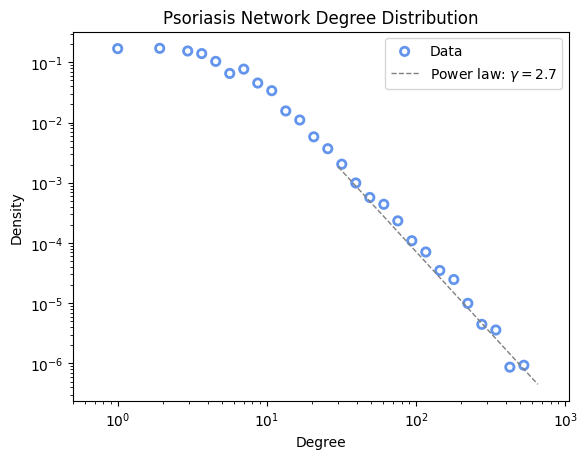

In [69]:
# Adapted from lecture notes 10 - Preferential Attachment
def log_binned_histogram(degree_sequence, interval = 5, num_bins = 20):
    hist, bins = np.histogram(degree_sequence, bins = min(int(len(degree_sequence)/interval), num_bins))
    bins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    hist, bins = np.histogram(degree_sequence, bins = bins)
    binwidths = bins[1:] - bins[:-1]
    hist = hist / binwidths
    p = hist/hist.sum()

    return bins[:-1], p

def plot_degree_distribution(deg_seq, **kwargs):

    x, p = log_binned_histogram(deg_seq, **kwargs)
    plt.scatter(x, p,  facecolors='none', edgecolors =  'cornflowerblue', linewidth = 2, label = "Data")
    plt.gca().set(xlabel = "Degree", xlim = (0.5, x.max()*2))
    plt.gca().set(ylabel = "Density")
    plt.gca().loglog()
    plt.legend()
    return plt.gca()

# Line of fit to power law degree sequence
deg_seq = np.array(largest_component.degree())
cutoff  = 30
d_      = np.arange(cutoff, deg_seq.max(), 1)
gamma   = 2.7
power_law = 18*d_**(-gamma)

ax = plot_degree_distribution(deg_seq, interval = 10, num_bins = 30)
ax.plot(d_, power_law,  linewidth = 1, label = fr"Power law: $\gamma = {gamma}$" , color = "grey", linestyle = "--")
plt.title('Psoriasis Network Degree Distribution')
ax.legend()
plt.show()

# **Chung-Lu Random Graph and Expected Degree Sequence**

In [200]:
# generating Chung-Lu model with igraph
K = largest_component.ecount()
chung_lu = Graph.Chung_Lu(variant="Original", loops=False, out=K)
chung_lu_largest_component = largest_component.components().giant()
deg_seq = np.array(chung_lu_largest_component.degree())

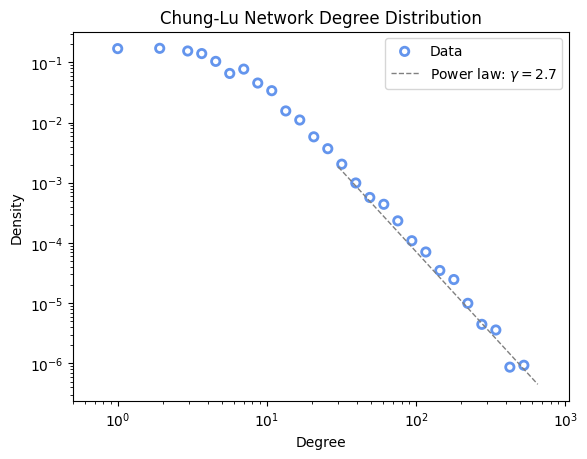

In [201]:
# plot log scaled degree sequence
cutoff  = 30
d_      = np.arange(cutoff, deg_seq.max(), 1)
gamma   = 2.7
power_law = 18*d_**(-gamma)

ax = plot_degree_distribution(deg_seq, interval = 10, num_bins = 30)
ax.plot(d_, power_law,  linewidth = 1, label = fr"Power law: $\gamma = {gamma}$" , color = "grey", linestyle = "--")
plt.title('Chung-Lu Network Degree Distribution')
ax.legend()
plt.show()

# **Kendall's Tau (Non-Parametric): Do High Degree Nodes Connect to Like High Degree Nodes?**

Please refer to this source in order to understand why non-parametric vs. parametric measures matter here: Litvak, Nelly & Hofstad, Remco. (2013). Uncovering disassortativity in large scale-free networks. Physical review. E, Statistical, nonlinear, and soft matter physics. 87. 022801. 10.1103/PhysRevE.87.022801.

## Preferential Attachment: An Assumption of Power Law Distributed Degree Sequence

In [180]:
def calculate_tau(graph):
    # Get degrees of all nodes
    degrees = {i: deg for i, deg in enumerate(graph.degree())}

    # Calculate average neighbor degree for each node
    avg_neighbor_degrees = {}
    for node in range(graph.vcount()):
        neighbors = graph.neighbors(node)
        if not neighbors: # If no neighbors, set the degree to 0
            avg_neighbor_degrees[node] = 0
            continue

        neighbor_degree_sum = sum(degrees[neighbor] for neighbor in neighbors)
        avg_neighbor_degrees[node] = neighbor_degree_sum / len(neighbors)

    # Create pairs for correlation
    degree_pairs = [(degrees[node], avg_neighbor_degrees[node]) for node in degrees.keys()] # {researchers degree: average degree of their collaborators}

    # Calculate correlation using Kendall's Tau
    tau, p_value = kendalltau(
        [pair[0] for pair in degree_pairs],
        [pair[1] for pair in degree_pairs])

    return tau, p_value, degrees, avg_neighbor_degrees

In [202]:
# information needed for preferential attachment models on the real network
K = g.degree()
n = g.vcount()
mean_K = int(mean(K)) # preferential attachment requires an integer, not float - /2????
#pref_attach_g = Graph.Barabasi(n, mean_K)

# compute tau over the actual network
tau_g, p_value_g, degrees_g, avg_neighbor_degrees_g = calculate_tau(g)

In [203]:
# sample from a distribution of preferential attachment models to generate simulated taus
sim_taus = []
for i in range(500):
    g_sim = Graph.Barabasi(n, mean_K)
    sim_tau, _, _, _ = calculate_tau(g_sim)
    sim_taus.append(sim_tau)

(array([ 2.,  3.,  4.,  4.,  4.,  8., 10.,  8., 18., 25., 21., 40., 39.,
        35., 39., 43., 34., 42., 27., 27., 16., 17., 12.,  5.,  6.,  6.,
         1.,  2.,  1.,  1.]),
 array([0.02096066, 0.02179399, 0.02262732, 0.02346065, 0.02429398,
        0.02512731, 0.02596064, 0.02679397, 0.0276273 , 0.02846063,
        0.02929396, 0.03012729, 0.03096062, 0.03179395, 0.03262728,
        0.03346062, 0.03429395, 0.03512728, 0.03596061, 0.03679394,
        0.03762727, 0.0384606 , 0.03929393, 0.04012726, 0.04096059,
        0.04179392, 0.04262725, 0.04346058, 0.04429391, 0.04512724,
        0.04596057]),
 <BarContainer object of 30 artists>)

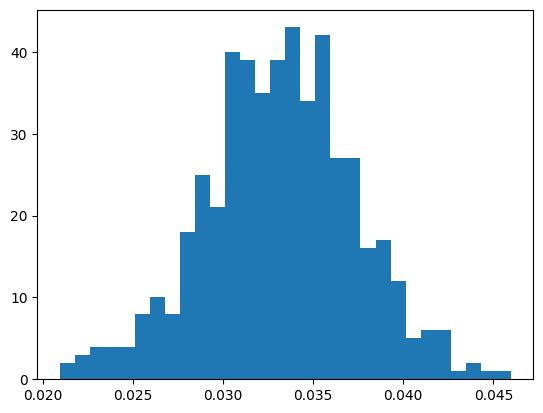

In [204]:
plt.hist(sim_taus, bins = 30)

In [205]:
sim_stdev = statistics.stdev(sim_taus)
sim_mean = mean(sim_taus)

z = (tau_g - sim_mean) / sim_stdev
print(f"Tau_g of {tau_g:.5f} is {z:.5f} standard deviations away from the simulation mean. With stdev: {sim_stdev:.5f} and mean: {sim_mean:.5f}")

z = (tau_g - sim_mean) / sim_stdev
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-score: {z}")
print(f"P-value: {p_value}")

Tau_g of 0.45305 is 99.50128 standard deviations away from the simulation mean. With stdev: 0.00422 and mean: 0.03318
Z-score: 99.50128301735369
P-value: 0.0


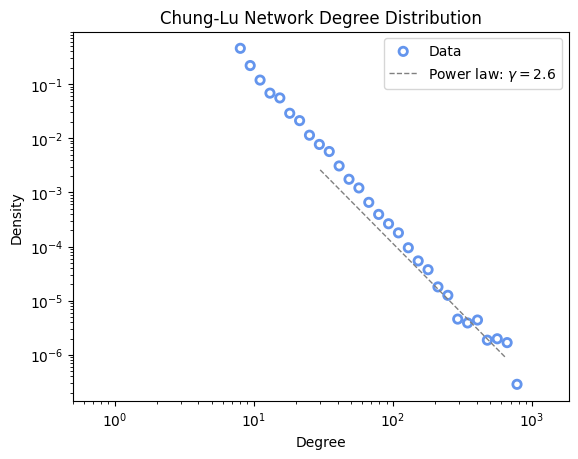

In [206]:
K = g.degree()
n = g.vcount()
mean_K = int(mean(K)) # preferential attachment requires an integer, not float - /2????
pref_attach_g = Graph.Barabasi(n, mean_K)

# plot log scaled degree sequence
cutoff  = 30
d_      = np.arange(cutoff, deg_seq.max(), 1)
gamma   = 2.6
power_law = 18*d_**(-gamma)

g_pa = Graph.Barabasi(n, mean_K)
deg_seq_pa = g_pa.degree()
ax = plot_degree_distribution(deg_seq_pa, interval = 10, num_bins = 30)
ax.plot(d_, power_law,  linewidth = 1, label = fr"Power law: $\gamma = {gamma}$" , color = "grey", linestyle = "--")
plt.title('Chung-Lu Network Degree Distribution')
ax.legend()
plt.show()

## Chung-Lu: True Null Model

In [207]:
# information needed for preferential attachment models on the real network
K = g.degree()
n = g.vcount()

# compute tau over the actual network
tau_g, p_value_g, degrees_g, avg_neighbor_degrees_g = calculate_tau(g)

In [208]:
# sample from a distribution of preferential attachment models to generate simulated taus
sim_taus = []

for i in range(500):
    g_sim = Graph.Chung_Lu(variant="Original", loops=False, out=K)
    sim_tau, _, _, _ = calculate_tau(g_sim)
    sim_taus.append(sim_tau)

(array([ 4.,  6.,  1.,  6., 15., 12., 20., 24., 26., 34., 29., 31., 49.,
        39., 35., 42., 18., 26., 20., 23., 15.,  9.,  5.,  6.,  2.,  1.,
         0.,  1.,  0.,  1.]),
 array([0.31385977, 0.3144552 , 0.31505062, 0.31564604, 0.31624147,
        0.31683689, 0.31743232, 0.31802774, 0.31862317, 0.31921859,
        0.31981401, 0.32040944, 0.32100486, 0.32160029, 0.32219571,
        0.32279113, 0.32338656, 0.32398198, 0.32457741, 0.32517283,
        0.32576826, 0.32636368, 0.3269591 , 0.32755453, 0.32814995,
        0.32874538, 0.3293408 , 0.32993622, 0.33053165, 0.33112707,
        0.3317225 ]),
 <BarContainer object of 30 artists>)

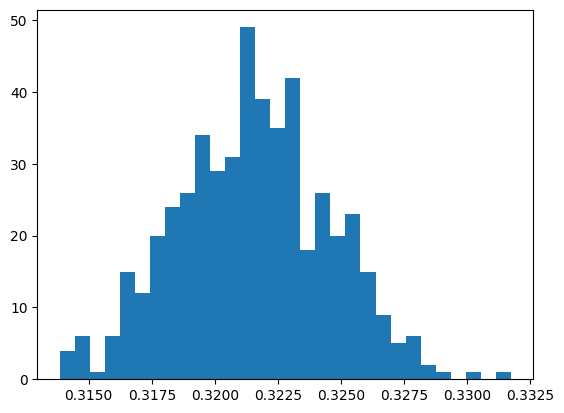

In [209]:
plt.hist(sim_taus, bins = 30)

In [210]:
sim_stdev = statistics.stdev(sim_taus)
sim_mean = mean(sim_taus)

z = (tau_g - sim_mean) / sim_stdev
print(f"Tau_g of {tau_g:.5f} is {z:.5f} standard deviations away from the simulation mean. With stdev: {sim_stdev:.5f} and mean: {sim_mean:.5f}")
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-score: {z}")
print(f"P-value: {p_value}")

Tau_g of 0.45305 is 43.64017 standard deviations away from the simulation mean. With stdev: 0.00301 and mean: 0.32151
Z-score: 43.64017455902789
P-value: 0.0


# **Degree Assortativity Over Random Graphs (Parametric)**

Please refer to this source in order to understand why non-parametric vs. parametric measures matter here: Litvak, Nelly & Hofstad, Remco. (2013). Uncovering disassortativity in large scale-free networks. Physical review. E, Statistical, nonlinear, and soft matter physics. 87. 022801. 10.1103/PhysRevE.87.022801.


## BA Model: Tends to Be Dissortative

In [108]:
# Actual graph
assortativity_g = g.assortativity_degree()

# Parameters of new graph
n = g.vcount()
K = g.degree()
mean_K = int(mean(K))
sim_assortativities = []

for i in range(500):
    g_sim = Graph.Barabasi(n, mean_K)
    assortativity = g_sim.assortativity_degree()
    sim_assortativities.append(assortativity)

(array([ 4.,  5.,  5., 10.,  8., 14., 18., 22., 37., 25., 37., 39., 45.,
        35., 44., 36., 32., 20., 16., 23.,  7.,  6.,  4.,  4.,  1.,  1.,
         1.,  0.,  0.,  1.]),
 array([-9.55923524e-04, -6.94937292e-04, -4.33951061e-04, -1.72964829e-04,
         8.80214023e-05,  3.49007634e-04,  6.09993865e-04,  8.70980097e-04,
         1.13196633e-03,  1.39295256e-03,  1.65393879e-03,  1.91492502e-03,
         2.17591125e-03,  2.43689749e-03,  2.69788372e-03,  2.95886995e-03,
         3.21985618e-03,  3.48084241e-03,  3.74182864e-03,  4.00281488e-03,
         4.26380111e-03,  4.52478734e-03,  4.78577357e-03,  5.04675980e-03,
         5.30774603e-03,  5.56873226e-03,  5.82971850e-03,  6.09070473e-03,
         6.35169096e-03,  6.61267719e-03,  6.87366342e-03]),
 <BarContainer object of 30 artists>)

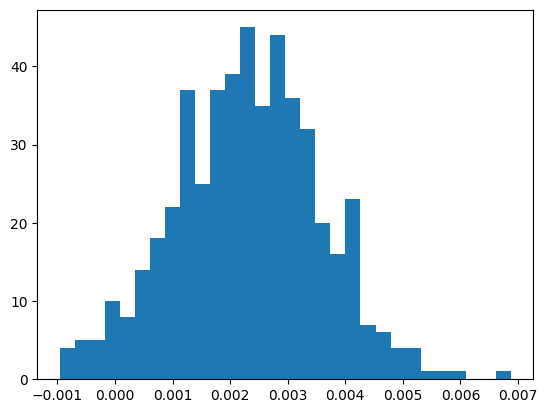

In [109]:
plt.hist(sim_assortativities, bins = 30)

In [110]:
sim_stdev = statistics.stdev(sim_assortativities)
sim_mean = mean(sim_assortativities)

z = (assortativity_g - sim_mean) / sim_stdev
print(f"Assortativity of {assortativity_g:.5f} is {z:.5f} standard deviations away from the simulation mean. With stdev: {sim_stdev:.5f} and mean: {sim_mean:.5f}")
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-score: {z}")
print(f"P-value: {p_value}")

Assortativity of 0.17016 is 132.77312 standard deviations away from the simulation mean. With stdev: 0.00126 and mean: 0.00231
Z-score: 132.7731181367759
P-value: 0.0


## Chung-Lu Model: True Null Model

In [102]:
# parameters for CL + actual assortativity
K = g.degree()
n = g.vcount()
assortativity_g = g.assortativity_degree()

# sample from a distribution of preferential attachment models to generate simulated taus
sim_assortativities = []

for i in range(500):
    g_sim = Graph.Chung_Lu(variant="Original", loops=False, out=K)
    assortativity = g_sim.assortativity_degree()
    sim_assortativities.append(assortativity)

(array([ 1.,  0.,  1.,  0.,  6.,  1.,  9., 14., 14., 23., 13., 37., 25.,
        28., 29., 57., 46., 40., 40., 19., 26., 18., 16., 15.,  6.,  8.,
         5.,  1.,  1.,  1.]),
 array([-0.00693427, -0.00655724, -0.00618022, -0.00580319, -0.00542617,
        -0.00504914, -0.00467211, -0.00429509, -0.00391806, -0.00354104,
        -0.00316401, -0.00278698, -0.00240996, -0.00203293, -0.00165591,
        -0.00127888, -0.00090185, -0.00052483, -0.0001478 ,  0.00022922,
         0.00060625,  0.00098328,  0.0013603 ,  0.00173733,  0.00211435,
         0.00249138,  0.0028684 ,  0.00324543,  0.00362246,  0.00399948,
         0.00437651]),
 <BarContainer object of 30 artists>)

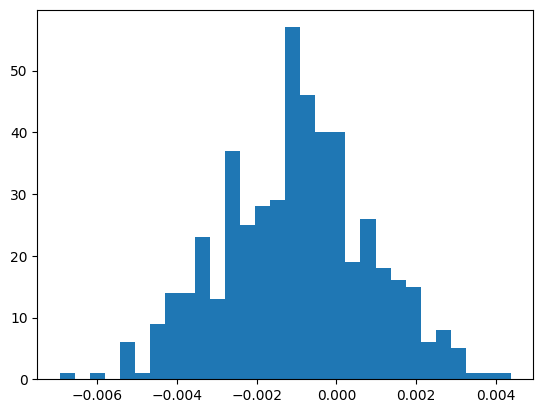

In [103]:
plt.hist(sim_assortativities, bins = 30)

In [104]:
sim_stdev = statistics.stdev(sim_assortativities)
sim_mean = mean(sim_assortativities)

z = (assortativity_g - sim_mean) / sim_stdev
print(f"Assortativity of {assortativity_g:.5f} is {z:.5f} standard deviations away from the simulation mean. With stdev: {sim_stdev:.5f} and mean: {sim_mean:.5f}")
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-score: {z}")
print(f"P-value: {p_value}")

Assortativity of 0.17016 is 92.77074 standard deviations away from the simulation mean. With stdev: 0.00185 and mean: -0.00100
Z-score: 92.77073981245091
P-value: 0.0


# **Spearman Correlation of Node and Neighbor Degrees (Non-Parametric)**

Litvak, Nelly & Hofstad, Remco. (2013). Uncovering disassortativity in large scale-free networks. Physical review. E, Statistical, nonlinear, and soft matter physics. 87. 022801. 10.1103/PhysRevE.87.022801.


## Preferential Attachment

In [105]:
def spearmanr_degree(g):
    degrees = g.degree()
    edge_degrees = [(degrees[e.source], degrees[e.target]) for e in g.es]
    if not edge_degrees:
        return float('nan')
    deg_u, deg_v = zip(*edge_degrees)
    return spearmanr(deg_u, deg_v).correlation

In [106]:
spearman_r_g = spearman_assortativity(g)

# Parameters of new graph
n = g.vcount()
K = g.degree()
mean_K = int(mean(K))
sim_spearmanr_degs = []

for i in range(500):
    g_sim = Graph.Barabasi(n, mean_K)
    spearman_r_deg = spearmanr_degree(g_sim)
    sim_spearmanr_degs.append(spearman_r_deg)

(array([ 1.,  1.,  1.,  0.,  3.,  7.,  3., 11., 14., 20., 22., 23., 40.,
        42., 38., 47., 45., 42., 32., 30., 22., 20.,  8.,  9., 10.,  3.,
         3.,  0.,  1.,  2.]),
 array([0.4088268 , 0.4091159 , 0.40940501, 0.40969412, 0.40998322,
        0.41027233, 0.41056144, 0.41085055, 0.41113965, 0.41142876,
        0.41171787, 0.41200697, 0.41229608, 0.41258519, 0.4128743 ,
        0.4131634 , 0.41345251, 0.41374162, 0.41403072, 0.41431983,
        0.41460894, 0.41489805, 0.41518715, 0.41547626, 0.41576537,
        0.41605447, 0.41634358, 0.41663269, 0.4169218 , 0.4172109 ,
        0.41750001]),
 <BarContainer object of 30 artists>)

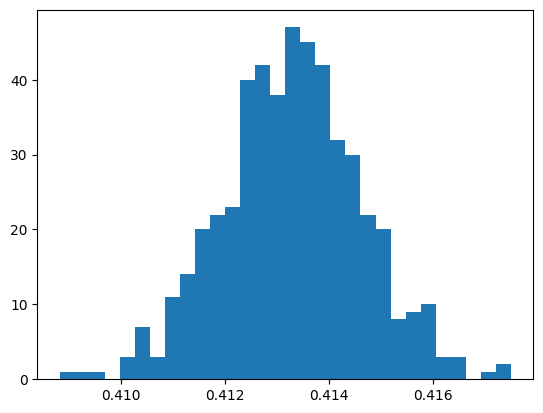

In [107]:
plt.hist(sim_spearmanr_degs, bins = 30)

In [75]:
sim_stdev = statistics.stdev(sim_spearmanr_degs)
sim_mean = mean(sim_spearmanr_degs)

z = (spearman_r_g - sim_mean) / sim_stdev
print(f"Correlation of {spearman_r_g:.5f} is {z:.5f} standard deviations away from the simulation mean. With stdev: {sim_stdev:.5f} and mean: {sim_mean:.5f}")
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-score: {z}")
print(f"P-value: {p_value}")

Assortativity of 0.44582 is 23.91661 standard deviations away from the simulation mean. With stdev: 0.00136 and mean: 0.41323
Z-score: 23.91661443211112
P-value: 0.0


## Chung Lu

In [77]:
spearman_r_g = spearman_assortativity(g)

# Parameters of new graph
K = g.degree()
n = g.vcount()
sim_spearmanr_degs = []

for i in range(500):
    g_sim = Graph.Chung_Lu(variant="Original", loops=False, out=K)
    spearman_r_deg = spearmanr_degree(g_sim)
    sim_spearmanr_degs.append(spearman_r_deg)

(array([ 1.,  2.,  1.,  3.,  5.,  4., 11., 15., 17., 23., 32., 30., 31.,
        44., 36., 22., 36., 32., 34., 26., 32., 22., 14.,  9.,  9.,  4.,
         2.,  1.,  1.,  1.]),
 array([-0.00662003, -0.00618761, -0.00575518, -0.00532276, -0.00489034,
        -0.00445791, -0.00402549, -0.00359307, -0.00316064, -0.00272822,
        -0.00229579, -0.00186337, -0.00143095, -0.00099852, -0.0005661 ,
        -0.00013368,  0.00029875,  0.00073117,  0.0011636 ,  0.00159602,
         0.00202844,  0.00246087,  0.00289329,  0.00332571,  0.00375814,
         0.00419056,  0.00462298,  0.00505541,  0.00548783,  0.00592026,
         0.00635268]),
 <BarContainer object of 30 artists>)

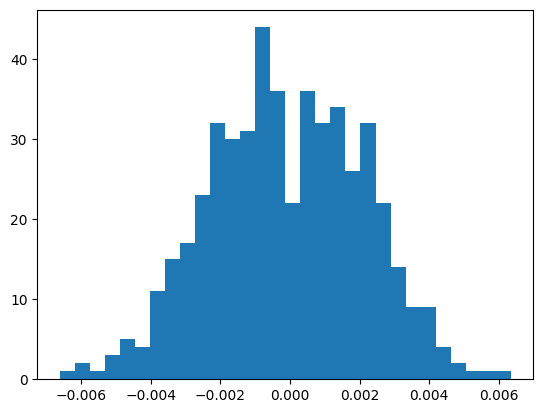

In [78]:
plt.hist(sim_spearmanr_degs, bins = 30)

In [79]:
sim_stdev = statistics.stdev(sim_spearmanr_degs)
sim_mean = mean(sim_spearmanr_degs)

z = (spearman_r_g - sim_mean) / sim_stdev
print(f"Correlation of {spearman_r_g:.5f} is {z:.5f} standard deviations away from the simulation mean. With stdev: {sim_stdev:.5f} and mean: {sim_mean:.5f}")
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-score: {z}")
print(f"P-value: {p_value}")

Correlation of 0.44582 is 201.18254 standard deviations away from the simulation mean. With stdev: 0.00222 and mean: -0.00010
Z-score: 201.1825383953506
P-value: 0.0


# **Centrality: Which Researchers Are Major Contributors? Does NIH Ranking, First Authorship/Last Authorship Status, and Citation Activity Agree?**

Text(0.5, 0, 'Eigenvector Centrality')

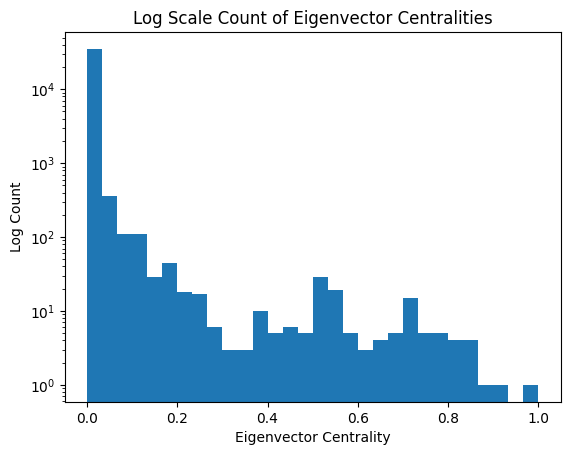

In [93]:
largest_component = g.components().giant()
eigvec_centralities = largest_component.eigenvector_centrality()

plt.hist(eigvec_centralities, bins = 30)
plt.yscale('log')
plt.title("Log Scale Count of Eigenvector Centralities")
plt.ylabel("Log Count")
plt.xlabel("Eigenvector Centrality")

## Centrality Correlation w/ Avg NIH Percentile

In [94]:
# WE CAN NOT ASSUME NORMALLY DISTRIBUTED NIH PERCENTILE SO WE USE KENDALL AND SPEARMANS RHO RANKED CORRELATIOn
giant_component = g.components().giant()
giant_ids = giant_component.vs['id']
giant_component_author_df = author_df[author_df['author_id'].isin(giant_ids)]
giant_component_nih = np.array(giant_component_author_df['avg_nih_percentile'])
eigvec_centralities = np.array(largest_component.eigenvector_centrality())

mask = ~np.isnan(giant_component_nih) & ~np.isnan(eigvec_centralities)

tau, p = kendalltau(eigvec_centralities[mask], giant_component_nih[mask])

print(f"Kendall's tau for avg_nih_percentile vs eigenvector_centrality: {tau}")
print(f"p value: {p}")

rho, p = spearmanr(eigvec_centralities[mask], giant_component_nih[mask])

print(f"Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: {rho}")
print(f"p value: {p}")

nih_rho = rho
nih_p = p

Kendall's tau for avg_nih_percentile vs eigenvector_centrality: 0.2728756991842915
p value: 0.0
Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: 0.3979634983364754
p value: 0.0


## Centrality Correlation w/ Avg Citations Per Paper

In [95]:
giant_component = g.components().giant()
giant_ids = giant_component.vs['id']
giant_component_author_df = author_df[author_df['author_id'].isin(giant_ids)]
giant_component_cit = np.array(giant_component_author_df['avg_citations'])
eigvec_centralities = np.array(largest_component.eigenvector_centrality())

mask = ~np.isnan(giant_component_cit) & ~np.isnan(eigvec_centralities)

tau, p = kendalltau(eigvec_centralities[mask], giant_component_cit[mask])

print(f"Kendall's tau for avg_nih_percentile vs eigenvector_centrality: {tau}")
print(f"p value: {p}")

rho, p = spearmanr(eigvec_centralities[mask], giant_component_cit[mask])

print(f"Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: {rho}")
print(f"p value: {p}")

acit_rho = rho
acit_p = p

Kendall's tau for avg_nih_percentile vs eigenvector_centrality: 0.30151419183775385
p value: 0.0
Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: 0.43658838047423704
p value: 0.0


## Centrality Correlation w/ Total Number of Publications

In [96]:
giant_component = g.components().giant()
giant_ids = giant_component.vs['id']
giant_component_author_df = author_df[author_df['author_id'].isin(giant_ids)]
giant_component_pub = np.array(giant_component_author_df['total_pubs'])
eigvec_centralities = np.array(largest_component.eigenvector_centrality())

mask = ~np.isnan(giant_component_pub) & ~np.isnan(eigvec_centralities)

tau, p = kendalltau(eigvec_centralities[mask], giant_component_pub[mask])

print(f"Kendall's tau for avg_nih_percentile vs eigenvector_centrality: {tau}")
print(f"p value: {p}")

rho, p = spearmanr(eigvec_centralities[mask], giant_component_pub[mask])

print(f"Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: {rho}")
print(f"p value: {p}")

pub_rho = rho
pub_p = p

Kendall's tau for avg_nih_percentile vs eigenvector_centrality: 0.20552574791858164
p value: 0.0
Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: 0.26646789904817647
p value: 0.0


## Centrality Correlation w/ First Authorship Status

In [97]:
giant_component = g.components().giant()
giant_ids = giant_component.vs['id']
giant_component_author_df = author_df[author_df['author_id'].isin(giant_ids)]
giant_component_fa = np.array(giant_component_author_df['n_first_author'])
eigvec_centralities = np.array(largest_component.eigenvector_centrality())

mask = ~np.isnan(giant_component_fa) & ~np.isnan(eigvec_centralities)

tau, p = kendalltau(eigvec_centralities[mask], giant_component_fa[mask])

print(f"Kendall's tau for avg_nih_percentile vs eigenvector_centrality: {tau}")
print(f"p value: {p}")

rho, p = spearmanr(eigvec_centralities[mask], giant_component_fa[mask])

print(f"Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: {rho}")
print(f"p value: {p}")

fa_rho = rho
fa_p = p

Kendall's tau for avg_nih_percentile vs eigenvector_centrality: 0.1795895688441006
p value: 1.7467342369566128e-216
Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: 0.23470610634632932
p value: 6.310974629216738e-216


## Centrality Correlation w/ Last Authorship Status

In [98]:
giant_component = g.components().giant()
giant_ids = giant_component.vs['id']
giant_component_author_df = author_df[author_df['author_id'].isin(giant_ids)]
giant_component_la = np.array(giant_component_author_df['n_last_author'])
eigvec_centralities = np.array(largest_component.eigenvector_centrality())

mask = ~np.isnan(giant_component_la) & ~np.isnan(eigvec_centralities)

tau, p = kendalltau(eigvec_centralities[mask], giant_component_la[mask])

print(f"Kendall's tau for avg_nih_percentile vs eigenvector_centrality: {tau}")
print(f"p value: {p}")

rho, p = spearmanr(eigvec_centralities[mask], giant_component_la[mask])

print(f"Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: {rho}")
print(f"p value: {p}")

la_rho = rho
la_p = p

Kendall's tau for avg_nih_percentile vs eigenvector_centrality: 0.04365849519098172
p value: 9.643405765150407e-14
Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: 0.05750222806132283
p value: 3.38372556753336e-14


## Centrality Correlation w/ Total Citations

In [99]:
giant_component = g.components().giant()
giant_ids = giant_component.vs['id']
giant_component_author_df = author_df[author_df['author_id'].isin(giant_ids)]
giant_component_tc = np.array(giant_component_author_df['total_citations'])
eigvec_centralities = np.array(largest_component.eigenvector_centrality())

mask = ~np.isnan(giant_component_tc) & ~np.isnan(eigvec_centralities)

tau, p = kendalltau(eigvec_centralities[mask], giant_component_tc[mask])

print(f"Kendall's tau for avg_nih_percentile vs eigenvector_centrality: {tau}")
print(f"p value: {p}")

rho, p = spearmanr(eigvec_centralities[mask], giant_component_tc[mask])

print(f"Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: {rho}")
print(f"p value: {p}")

tcit_rho = rho
tcit_p = rho

Kendall's tau for avg_nih_percentile vs eigenvector_centrality: 0.3439829759402614
p value: 0.0
Spearmans rank correlation for avg_nih_percentile vs eigenvector_centrality: 0.49220059741096694
p value: 0.0


## Sanity Check: Eigvec Centrality vs Degree Centrality

In [100]:
giant_component = g.components().giant()
giant_ids = giant_component.vs['id']
eigvec_centralities = np.array(largest_component.eigenvector_centrality())
degree_centralities = np.array(giant_component.degree())

tau, p = kendalltau(eigvec_centralities, degree_centralities)

print(f"Kendall's tau for degree vs eigenvector_centrality: {tau}")
print(f"p value: {p}")

rho, p = spearmanr(eigvec_centralities, degree_centralities)

print(f"Spearmans rank correlation for degree vs eigenvector_centrality: {rho}")
print(f"p value: {p}")

deg_rho = rho
deg_p = p

Kendall's tau for degree vs eigenvector_centrality: 0.32663218611466416
p value: 0.0
Spearmans rank correlation for degree vs eigenvector_centrality: 0.4574745874808227
p value: 0.0


## Heatmap Correlation Summary

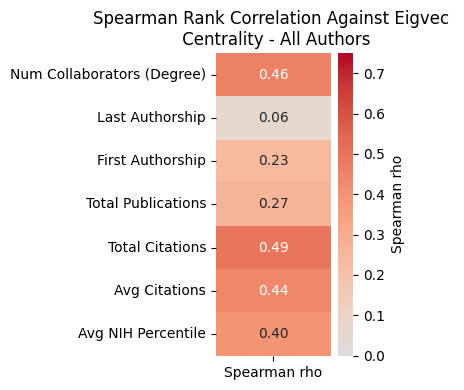

In [101]:
labels = ["Avg NIH Percentile", "Avg Citations", "Total Citations", "Total Publications", "First Authorship", "Last Authorship", "Num Collaborators (Degree)"]
rhos = [nih_rho, acit_rho, tcit_rho, pub_rho, fa_rho, la_rho, deg_rho]
ps = [nih_p, acit_p, tcit_p, pub_p, fa_p, la_p, deg_p]

# Create DataFrame for the heatmap
uniform_data = pd.DataFrame([rhos], columns=labels)
vmin, vmax = 0, 0.75

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format
# https://stackoverflow.com/questions/63892337/how-to-rotate-seaborn-heatmap-in-python
# https://stackoverflow.com/questions/42092218/how-to-add-a-label-to-seaborn-heatmap-color-bar
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(uniform_data.T, annot=True, cmap='coolwarm', fmt=".2f", center=0, cbar_kws={"label": "Spearman rho"}, ax=ax, vmin=vmin, vmax=vmax)
ax.invert_yaxis()
if ONLY_FREQUENT_PUBLISHERS:
    plt.title(f"Spearman Rank Correlation Against Eigvec \n Centrality - Authors w/ {MINIMUM_PAPERS}+ Pubs")
else:
    plt.title("Spearman Rank Correlation Against Eigvec \n Centrality - All Authors")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel("Spearman rho")

# https://stackoverflow.com/questions/12998430/how-to-remove-xticks-from-a-plot
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

# **Assortativity Over Metrics**

In [21]:
avg_citations = author_df['avg_citations']
avg_citations = author_df['avg_citations'].fillna(author_df['avg_citations'].mean())
avg_citation_homophily = g.assortativity(avg_citations)
print(avg_citation_homophily)

0.4209103776014931


In [22]:
nih_percentiles = author_df['avg_nih_percentile']
nih_percentiles_filled = nih_percentiles.fillna(nih_percentiles.mean())
nih_percentile_homophily = g.assortativity(nih_percentiles_filled)
print(nih_percentile_homophily)

0.5034405188858012


In [23]:
relative_citation_ratios = author_df['avg_relative_citation_ratio']
relative_citation_ratios_filled = relative_citation_ratios.fillna(relative_citation_ratios.mean())
relative_citation_homophily = g.assortativity(relative_citation_ratios_filled)
print(relative_citation_homophily)

0.3930619612808667


In [24]:
total_citations = author_df['total_citations']
total_citations_filled = total_citations.fillna(total_citations.mean())
total_citation_homophily = g.assortativity(total_citations_filled)
print(total_citation_homophily)

0.09541582809338388


In [25]:
total_pubs = author_df['total_pubs']
total_pubs_filled = total_pubs.fillna(total_pubs.mean())
total_pub_homophily = g.assortativity(total_pubs_filled)
print(total_pub_homophily)

0.014091732030874124


In [26]:
# Degree assortativity again...
n_collaborations = author_df['n_collaborations']
n_collaborations_filled = n_collaborations.fillna(n_collaborations.mean())
collaboration_homophily = g.assortativity(n_collaborations_filled)
print(collaboration_homophily)

0.11945697918233542


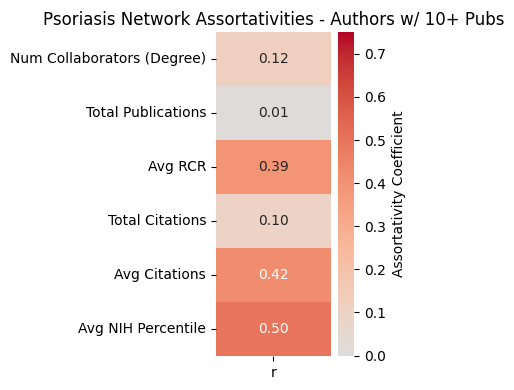

In [27]:
labels = ["Avg NIH Percentile", "Avg Citations", "Total Citations", "Avg RCR", "Total Publications", "Num Collaborators (Degree)"]
assortativities = [nih_percentile_homophily, avg_citation_homophily, total_citation_homophily, relative_citation_homophily, total_pub_homophily, collaboration_homophily]
uniform_data = pd.DataFrame([assortativities], columns=labels)

vmin, vmax = 0, 0.75
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(uniform_data.T, annot=True, cmap='coolwarm', fmt=".2f", center=0, cbar_kws={"label": "Assortativity Coefficient"}, ax=ax, vmin=vmin, vmax=vmax)
ax.invert_yaxis()

if ONLY_FREQUENT_PUBLISHERS:
    plt.title(f"Psoriasis Network Assortativities - Authors w/ {MINIMUM_PAPERS}+ Pubs")
else:
    plt.title("Psoriasis Network Assortativities - All Authors")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel("r")
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

# **Network Clustering Visualization**

Modularity: 0.53


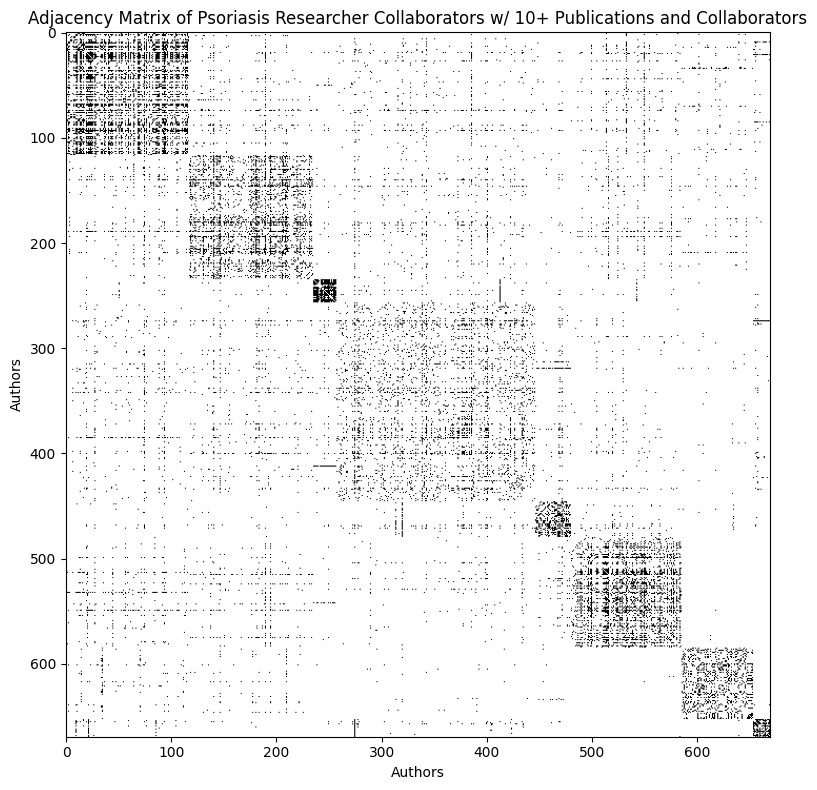

In [9]:
# Nodes with degree >= 10 and at least 10 publications in psoriasis research, and then the giant component over that...
degree_threshold = 10
selected_vertices = [v.index for v in g.vs if g.degree(v) >= degree_threshold]
filtered_graph = g.subgraph(selected_vertices)
giant_component = filtered_graph.components().giant()

# Apply the louvain method to cluster
clusters = giant_component.community_multilevel()
print(f"Modularity: {clusters.modularity:.2f}")
membership = np.array(clusters.membership)
sorted_indices = np.argsort(membership)
adj_list = giant_component.get_adjacency().data

# Created the sorted adjacency matrix
# DISCLAIMER: I got stuck on figuring out how to apply my unordered adjacency list, so I used assitance of LLMs to figure out
# proper iteration and construction of approximate-block diagonal cluster adjacency matrix below:
n_nodes = giant_component.vcount()
sorted_adj_matrix = np.zeros((n_nodes, n_nodes))
for i in range(n_nodes):
    original_row_index = sorted_indices[i]
    sorted_adj_matrix[i, :] = [adj_list[original_row_index][j] for j in sorted_indices]

plt.figure(figsize=(8, 8))
plt.imshow(sorted_adj_matrix, cmap="binary")
if ONLY_FREQUENT_PUBLISHERS:
    plt.title("Adjacency Matrix of Psoriasis Researcher Collaborators w/ 10+ Publications and Collaborators")
else:
    plt.title("Adjacency Matrix of Psoriasis Researcher Collaborators w/ 10+ Collaborators")
plt.xlabel("Authors")
plt.ylabel("Authors")
plt.tight_layout()
plt.show()

In [10]:
print(clusters)

Clustering with 670 elements and 8 clusters
[0] Abecasis, Gonçalo R, Alenius, Gerd-Marie, Allen, Michael H, Anstey, Alex
    V, Baker, Barbara S, Barker, Jonathan N W N, Barton, Anne, Behrens, Frank,
    Bergboer, Judith G M, Bowcock, Anne M, Bowes, John, Bruce, Ian N, Burden,
    A David, Burkhardt, Harald, Böhm, Beate, Capon, Francesca, Chandran,
    Vinod, Cork, Michael J, Cui, Yong, Di Meglio, Paola, Ding, Jun, Eder,
    Lihi, Elder, James T, Estivill, Xavier, Fan, Xing, Farewell, Vernon T,
    Fazio, M, Foerster, John, Franke, Andre, Gao, Min, Giardina, Emiliano,
    Griffiths, Christopher E M, Groves, Richard W, Gudjonsson, Johann E,
    Hagforsen, Eva, Helms, Cynthia, Ho, Pauline, Hofer, Angelika, Huang, Wei,
    Hüffmeier, Ulrike, Inerot, Annica, Inoko, Hidetoshi, Jenisch, Stefan,
    Johnston, Andrew, Kane, David, Kere, Juha, Kingo, Külli, Kirby, Brian,
    Korendowych, Eleanor, Kwok, Pui-Yan, Kõks, Sulev, Lascorz, Jesús, Liao,
    Wilson, Lim, Henry W, Liu, Jian-Jun, Mabuchi,